In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

aa_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}
aa_list = ["ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"]


# this function helps you to convert the listed data in dataframe into a list (plddt etc.)
def string_to_float_list(string):
    return [float(i) if i!='None' else None for i in string.split(',') ]

# this function helps you to convert the sequence data in dataframe into a list (secondary structure etc.)
def ss_string_to_list(string):
    return [float(i) for i in string.strip('][').split(',')]

def merge_list(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

def filter_function(df):
    filter_list = []
    for i in range(len(df)):
        if df['model_1_ptm_avg_plddt'][i] >= 70 and df['model_2_ptm_avg_plddt'][i] > 70 and df['model_3_ptm_avg_plddt'][i] > 70 and df['model_4_ptm_avg_plddt'][i] > 70 and df['model_5_ptm_avg_plddt'][i] >= 70:
            filter_list.append(True)
        else:
            filter_list.append(False)
    return filter_list

In [2]:
# feature in dataframe:
# ID, name, sequence, sequence_length, structure_avail, [model_name]_avg_plddt
# with model name: disulfide_bond, hydrogen_bond, salt_bridge, surface, SASA, secondary_structure, chirality, phi_angle, psi_angle, omega_angle, plddt

In [3]:
# Define function to calculate secondary structure percentage
def calc_ss_percent(ss_string):
    Helix_len = 0
    Sheet_len = 0
    LoopR_len = 0

    for i in range(len(ss_string)):
        if ss_string[i] == 'H':
            Helix_len += 1
        elif ss_string[i] == 'S':
            Sheet_len += 1
        elif ss_string[i] == 'L':
            LoopR_len += 1
        else:
            return BaseException
    return Helix_len/len(ss_string),Sheet_len/len(ss_string),LoopR_len/len(ss_string)

In [4]:
# read data
df_A501 = pd.read_csv('A501_results.tsv', sep='\t')
df_3DAC = pd.read_csv('3DAC_results.tsv', sep='\t')

df_list = [df_A501,df_3DAC]
tick_list = ["A501","3DAC"]
color_list = ["tab:red","tab:blue"]
cmap_list = ["Reds","Blues"]


# Calculate secondary structure percentage
for j in range(len(df_list)):

    ss_H_list = []
    ss_S_list = []
    ss_L_list = []
    for i in range(df_list[j].shape[0]):
        ss_H,ss_S,ss_L = calc_ss_percent(df_list[j]["secondary_structure_relaxed_model_3_ptm"][i])
        ss_H_list.append(ss_H)
        ss_S_list.append(ss_S)
        ss_L_list.append(ss_L)
    df_list[j]["ss_H"] = ss_H_list
    df_list[j]["ss_S"] = ss_S_list
    df_list[j]["ss_L"] = ss_L_list

print("A501 removed:",df_A501.shape[0]-sum(filter_function(df_A501)))
print("3DAC removed:",df_3DAC.shape[0]-sum(filter_function(df_3DAC)))


A501 removed: 158
3DAC removed: 304


In [6]:
df_A501["omega_angle_relaxed_model_1_ptm"][0]

'176.880,169.425,162.636,-177.229,164.990,176.060,172.582,160.145,177.378,168.742,170.225,165.238,-178.805,-179.274,165.639,-176.027,172.369,178.266,-172.195,177.050,-179.373,163.548,-177.010,175.983,174.181,177.891,167.068,172.878,-177.834,178.946,175.733,-178.365,-176.618,163.511,178.227,-178.737,172.345,170.902,176.857,172.392,-177.054,178.785,-174.551,179.402,172.508,168.566,-172.297,167.369,180.000,-178.620,173.147,171.343,167.270,175.501,174.235,163.339,173.461,-179.923,173.130,174.203,-179.503,165.566,-173.746,169.471,171.299,-179.427,174.291,-175.801,169.931,179.937,178.072,-177.147,-175.480,-178.422,173.529,166.926,-177.286,165.384,177.618,170.922,174.112,-177.674,177.537,173.571,177.039,173.159,175.239,168.458,-174.284,170.685,179.174,174.736,-178.274,177.399,173.232,179.517,179.539,172.765,176.693,-174.641,169.056,-176.055,176.951,170.864,179.470,-178.217,166.177,174.157,178.838,-178.459,173.144,176.577,176.259,170.231,175.940,-175.285,172.784,-177.921,177.545,-173.764,171.8

In [9]:
def count_w_torsion(df,model_name):
    count = [[0,0,0],[0,0,0],[0,0,0],[0,0,0]]    # Xaa-Xaa, Xaa-Pro, Pro-Xaa, Pro-Pro, in one list [trans, cis(-45 to 45), strange]
    for i in range(df.shape[0]):
        omega_angle_list = string_to_float_list(df["omega_angle_"+model_name][i])
        for j in range(df["sequence_length"][i]-1):
            # Xaa-Xaa
            if df["sequence"][i][j] == "P":
                if df["sequence"][i][j+1] == "P":
                    index_1 = 3
                else:
                    index_1 = 2
            else:
                if df["sequence"][i][j+1] == "P":
                    index_1 = 1
                else:
                    index_1 = 0
                
            # angle range
            if omega_angle_list[j] <= -135 or omega_angle_list[j] >= 135:
                count[index_1][0] += 1
            elif omega_angle_list[j] >= -45 and omega_angle_list[j] <= 45:
                count[index_1][1] += 1

    return count

In [10]:
chirality_result_A501 = [[],[],[],[],[],[],[],[],[],[]]
chirality_result_A501[0] = count_w_torsion(df_A501,"relaxed_model_1_ptm")
chirality_result_A501[1] = count_w_torsion(df_A501,"relaxed_model_2_ptm")
chirality_result_A501[2] = count_w_torsion(df_A501,"relaxed_model_3_ptm")
chirality_result_A501[3] = count_w_torsion(df_A501,"relaxed_model_4_ptm")
chirality_result_A501[4] = count_w_torsion(df_A501,"relaxed_model_5_ptm")
chirality_result_A501[5] = count_w_torsion(df_A501,"unrelaxed_model_1_ptm")
chirality_result_A501[6] = count_w_torsion(df_A501,"unrelaxed_model_2_ptm")
chirality_result_A501[7] = count_w_torsion(df_A501,"unrelaxed_model_3_ptm")
chirality_result_A501[8] = count_w_torsion(df_A501,"unrelaxed_model_4_ptm")
chirality_result_A501[9] = count_w_torsion(df_A501,"unrelaxed_model_5_ptm")

In [11]:
chirality_result_3DAC = [[],[],[],[],[],[],[],[],[],[]]
chirality_result_3DAC[0] = count_w_torsion(df_3DAC,"relaxed_model_1_ptm")
chirality_result_3DAC[1] = count_w_torsion(df_3DAC,"relaxed_model_2_ptm")
chirality_result_3DAC[2] = count_w_torsion(df_3DAC,"relaxed_model_3_ptm")
chirality_result_3DAC[3] = count_w_torsion(df_3DAC,"relaxed_model_4_ptm")
chirality_result_3DAC[4] = count_w_torsion(df_3DAC,"relaxed_model_5_ptm")
chirality_result_3DAC[5] = count_w_torsion(df_3DAC,"unrelaxed_model_1_ptm")
chirality_result_3DAC[6] = count_w_torsion(df_3DAC,"unrelaxed_model_2_ptm")
chirality_result_3DAC[7] = count_w_torsion(df_3DAC,"unrelaxed_model_3_ptm")
chirality_result_3DAC[8] = count_w_torsion(df_3DAC,"unrelaxed_model_4_ptm")
chirality_result_3DAC[9] = count_w_torsion(df_3DAC,"unrelaxed_model_5_ptm")

In [13]:
chirality_result_A501[0]

[[570640, 852, 0], [25358, 1067, 0], [26396, 19, 0], [1121, 93, 0]]

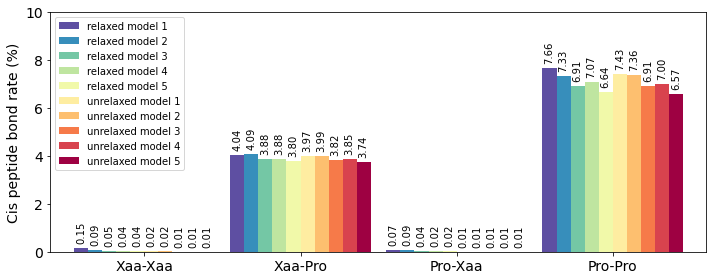

In [23]:
color_list = [plt.cm.Spectral_r(i) for i in np.linspace(0,1,10)]
model_names = ["relaxed model 1","relaxed model 2","relaxed model 3","relaxed model 4","relaxed model 5","unrelaxed model 1","unrelaxed model 2","unrelaxed model 3","unrelaxed model 4","unrelaxed model 5"]


plt.figure(figsize=(10,4))

for model_index in range(10):
    cis_w_rate = [type[1]/sum(type)*100 for type in chirality_result_A501[model_index]]
    plt.bar(np.arange(4)+model_index*0.09,cis_w_rate,width=0.09,color=color_list[model_index],label=model_names[model_index])
    for i in range(4):
        plt.text(i+model_index*0.09,cis_w_rate[i]+0.2,"%.2f"%(cis_w_rate[i]),ha="center",va="bottom",fontsize=10,rotation=90)

plt.xlim(-0.2,4)
plt.xticks(np.arange(4)+0.405,["Xaa-Xaa", "Xaa-Pro", "Pro-Xaa", "Pro-Pro"],fontsize=14)
plt.ylabel("Cis peptide bond rate (%)",fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,10)
plt.legend(fontsize=10)


plt.tight_layout()
plt.savefig("A501_cis.png",dpi=300,bbox_inches="tight")

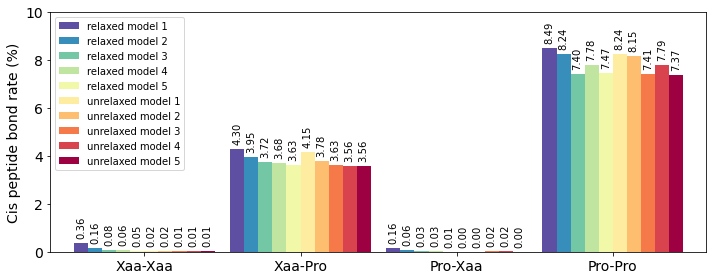

In [24]:
color_list = [plt.cm.Spectral_r(i) for i in np.linspace(0,1,10)]
model_names = ["relaxed model 1","relaxed model 2","relaxed model 3","relaxed model 4","relaxed model 5","unrelaxed model 1","unrelaxed model 2","unrelaxed model 3","unrelaxed model 4","unrelaxed model 5"]


plt.figure(figsize=(10,4))

for model_index in range(10):
    cis_w_rate = [type[1]/sum(type)*100 for type in chirality_result_3DAC[model_index]]
    plt.bar(np.arange(4)+model_index*0.09,cis_w_rate,width=0.09,color=color_list[model_index],label=model_names[model_index])
    for i in range(4):
        plt.text(i+model_index*0.09,cis_w_rate[i]+0.2,"%.2f"%(cis_w_rate[i]),ha="center",va="bottom",fontsize=10,rotation=90)

plt.xlim(-0.2,4)
plt.xticks(np.arange(4)+0.405,["Xaa-Xaa", "Xaa-Pro", "Pro-Xaa", "Pro-Pro"],fontsize=14)
plt.ylabel("Cis peptide bond rate (%)",fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,10)
plt.legend(fontsize=10)


plt.tight_layout()
plt.savefig("3DAC_cis.png",dpi=300,bbox_inches="tight")